In [32]:
from madigan.environments import make_env
from madigan.utils.preprocessor import StackerDiscrete, StackerDiscretePairs
from madigan.utils.config import make_config

import numpy as np
import matplotlib.pyplot as plt

In [33]:
config_sine = make_config("sineComp", assets=["sineC1"],
                          data_source_type="SineAdder",
                          data_source_config={
                            'freq':[2.2, 4.1, 1., 3.],
                            'mu':[.6, 0.3, 2., 4.2],
                            'amp':[.5, 0.2, 0.4, 1.2],
                            'phase':[0., 1., 4., 0.],
                            'dX':0.01,
                            "noise": 0.0},
                         )
env_sine = make_env(config_sine)


In [57]:
config_ou = make_config("OU", assets=["ou1"],
                        data_source_type="OU",
                        data_source_config=dict(
                            mean=[10., 5., 1.],
                            theta=[.08, .15, .15],
                            phi = [.04, .04, .04])
                        )
env_ou = make_env(config_ou)

In [58]:
config_ou_pair = make_config("OUPair",
                            data_source_type="OUPair",
                            data_source_config=dict(
                                theta=.15,
                                phi = .04,
                            noise = .03)
                            )
env_ou_pair = make_env(config_ou_pair)

In [59]:
env_sine.assets , env_ou.assets, env_ou_pair.assets

([multi_sine], [OU_0, OU_1, OU_2], [OUPair_0, OUPair_1])

In [60]:
window_sine = StackerDiscrete(128, env_sine.nAssets)
window_ou = StackerDiscrete(128, norm=False, n_assets=env_ou.nAssets) 
window_ou_pair1 = StackerDiscrete(128, norm=False, n_assets=env_ou_pair.nAssets) 
window_ou_pair2 = StackerDiscretePairs(128, norm=False, n_assets=env_ou_pair.nAssets) 
window_ou_pair3 = StackerDiscretePairs(128, norm=True, norm_type='standard_normal', n_assets=env_ou_pair.nAssets) 

In [61]:
env_sine.reset()
env_ou.reset()
env_ou_pair.reset()

Text(0.5, 1.0, 'OU Pair Pair Stacker Std Norm')

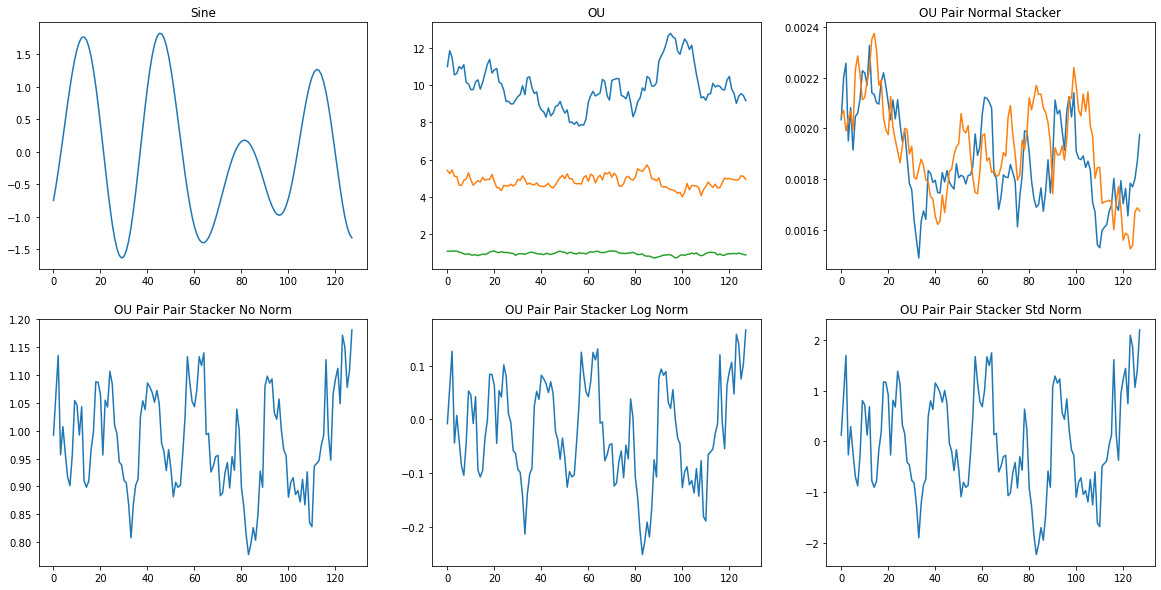

In [73]:
for i in range(1280):
    window_sine.stream(env_sine.step())
    window_ou.stream(env_ou.step())
    pair_data = env_ou_pair.step()
    window_ou_pair1.stream(pair_data)
    window_ou_pair2.stream(pair_data)
    window_ou_pair3.stream(pair_data)
# while env_ou_pair.step()[0].price[0] != np.nan:
#     window_sine.stream(env_ou_pair.step())

fig, axes = plt.subplots(2,3, figsize=(20, 10))
ax = axes.flatten()
ax[0].plot(window_sine.current_data().price, label='sine')
ax[0].set_title('Sine')
ax[1].plot(window_ou.current_data().price, label='ou')
ax[1].set_title('OU')
ax[2].plot(window_ou_pair1.current_data().price)
ax[2].set_title('OU Pair Normal Stacker')
ax[3].plot(window_ou_pair2.current_data().price)
ax[3].set_title('OU Pair Pair Stacker No Norm')
ax[4].plot(np.log(window_ou_pair2.current_data().price))
ax[4].set_title('OU Pair Pair Stacker Log Norm')
ax[5].plot(window_ou_pair3.current_data().price)
ax[5].set_title('OU Pair Pair Stacker Std Norm')

In [40]:
nan = window_ou_pair.current_data().price[0][0]

NameError: name 'window_ou_pair' is not defined

In [ ]:
from env

In [ ]:
import numba

@numba.njit
def trend_ou():
    x = 0.
    y = 1
    ema = y
    dx = 0.01
    dy = 0.001
    theta = 1
    phi = .5
    noise_var = 0.01
    emaAlpha = 0.9
    
    trending = False
    directions = np.array((-1, 1))
    current_direction = directions[1]
    noise = 0.05
    trend_len=0
    prev_y = y
    ou_noise = 0.
    ou_process = 0.
    while True:
#         prev_y = y
#         ema = emaAlpha*y + (1-emaAlpha)*ema
        if trending:
            y += y*dy*current_direction +  y*np.random.normal(0, noise_var)
            y = max(0.01, y)
            trend_len -= 1
            if trend_len == 0:
                trending=False
                prev_y = y
            if y <= 0.01:
                current_direction = 1
            
        else:
            ou_noise = y*phi*np.random.normal(0, noise)
            ou_process = theta*(prev_y-y)
#             print(ou_noise, ou_process, ou_noise+ou_process, y, prev_y)
            y += ou_process + ou_noise
            if np.random.random() < 0.001:
                trending = True
                current_direction = np.random.choice(directions)
                trend_len = np.random.randint(low=500, high=1500)
#         y += y * noise * np.random.normal(0., noise)
#         ou_noise = y*phi*np.random.normal(0, noise)
# #         ou_process = theta*((y+ou_noise)-y)
#         ou_process = theta*(y+ou_noise-prev_y)
#         ou_process = 0.
        trend_process = y
#         y += ou_process + ou_noise
        yield y, ema, ou_process, trend_process, prev_y, ou_noise
        

In [77]:
synth = iter(trend_ou())

Text(0.5, 1.0, 'ou process')

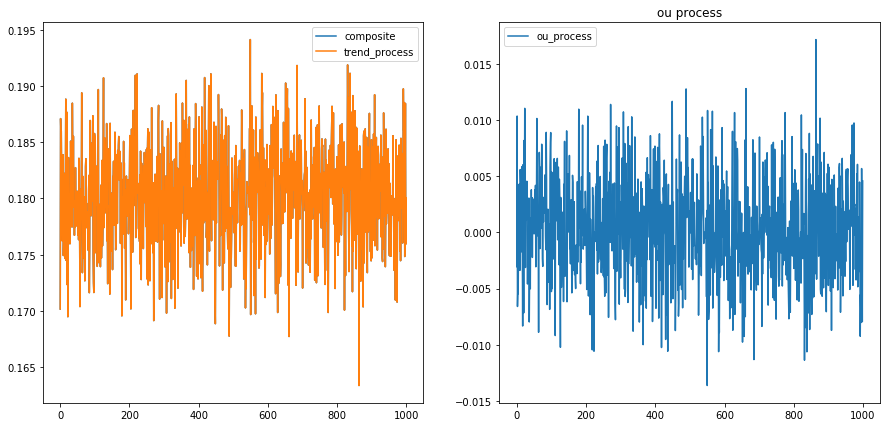

In [85]:
data = []
for i in range(1000):
    data.append(next(synth))
    
data = np.array(data)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(data[:, 0], label="composite")
# ax[0].plot(data[:, 1], label="ema")
ax[0].plot(data[:, 3], label="trend_process")
# ax[0].plot(data[:, 4], label="prev_y")
ax[1].plot(data[:, 2], label="ou_process")
# ax[1].plot(data[:, 5], label="ou_noise")
ax[0].legend()
ax[1].legend()
ax[1].set_title('ou process')